In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os
import talib
import labeling
from tree import train_ensemble, evaluate_ensemble, get_predicted_label_sequence

In [135]:
import trading_signal  
import importlib

importlib.reload(trading_signal)

from trading_signal import vol_long_short_strategy

In [191]:
import importlib
import picture

importlib.reload(picture)

<module 'picture' from '/Users/zoer/Documents/QTS/Crypto_trading_technical_indicators/picture.py'>

In [103]:
import importlib
import factors

importlib.reload(factors)

<module 'factors' from '/Users/zoer/Documents/QTS/Crypto_trading_technical_indicators/factors.py'>

In [102]:
import trading_signal  

importlib.reload(trading_signal)

from trading_signal import long_short_strategy
from trading_signal import long_only_strategy
from trading_signal import short_only_strategy

In [4]:
import importlib
import metrics  

importlib.reload(metrics)

from metrics import evaluate_strategy
from metrics import calculate_cumulative_asset

In [122]:
import pandas as pd
BTC = pd.read_pickle("data/cpt_5min/k_data/BTCUSD.pkl")
# Function to convert string columns to float
def convert_string_to_float(df):
    # Identify columns with string (object) data type
    string_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # Convert string columns to float where possible
    for col in string_columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float, set errors to NaN if conversion fails
        except Exception as e:
            print(f"Error converting column {col} to float: {e}")
    
    return df

# Convert string columns to float
BTC = convert_string_to_float(BTC)

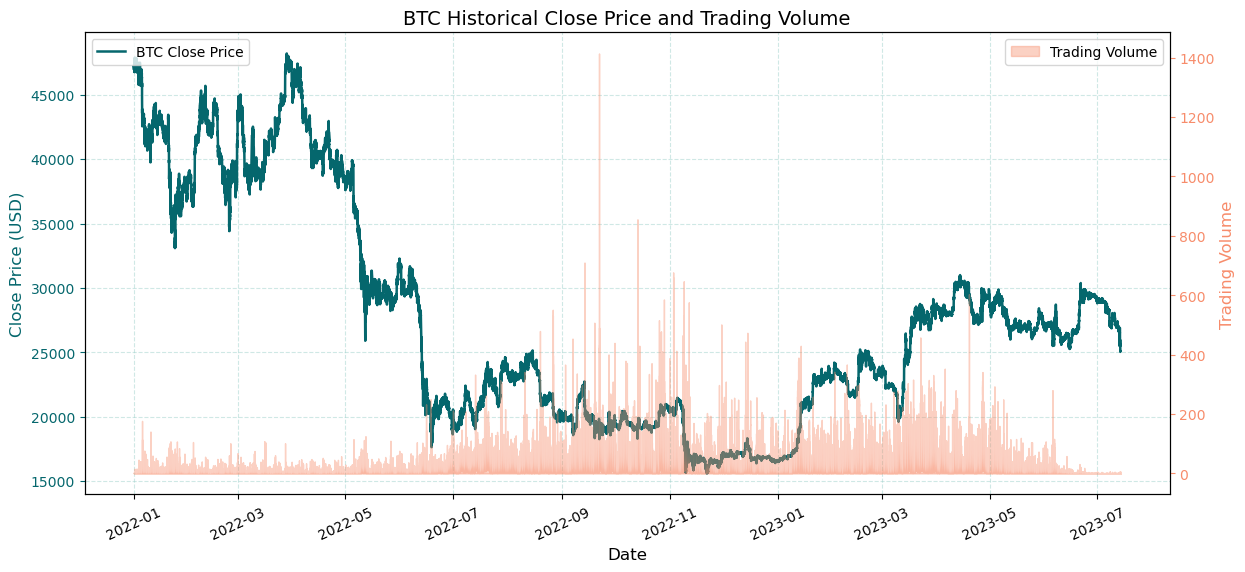

In [133]:
picture.plot_btc_price_and_volume(BTC)

In [123]:
start = BTC.index[0]
end = BTC.index[-1]

In [125]:
window_size = 15000  
moving_avg = BTC.rolling(window=window_size).mean()
detrended_series = BTC - moving_avg
detrended_series = detrended_series.dropna()

df_indicators_detrend = factors.compute_technical_indicators(detrended_series, start, end)
df_indicators_detrend = factors.restructure_dataframe(df_indicators_detrend)

In [128]:
def compute_future_returns(df, BTC, future_intervals=[5, 10, 15, 20, 25, 30]):

    # Compute future returns and store in a dictionary
    future_returns = {
        f"Future {interval}m Return": BTC["close"].pct_change(periods=interval).shift(-interval) for interval in future_intervals
    }

    # Convert the dictionary to a DataFrame with MultiIndex columns
    future_returns_df = pd.DataFrame(future_returns, index=df.index)
    future_returns_df.columns = pd.MultiIndex.from_tuples(
        [("Revenue", col) for col in future_returns_df.columns], names=["Category", "Factor"]
    )

    # Concatenate the original DataFrame with the new future return columns
    df_extended = pd.concat([df, future_returns_df], axis=1)

    return df_extended

df_extended = compute_future_returns(df_indicators_detrend.loc['2022'], BTC)
revenue_columns = [col for col in df_extended.columns if col[0] == "Revenue"]
factor_correlations = df_extended.corr().loc[:, revenue_columns].drop(index=revenue_columns)

Here, only the data from 2022 is used to calculate the correlation to prevent future data

In [129]:
def generate_numerical_signal(category, factor_name, factor_values, corr_value, quantile_levels):
    if quantile_levels is None:
        raise ValueError("Quantile levels must be provided for numerical factors.")

    # Compute quantile thresholds
    quantiles = factor_values.quantile(quantile_levels).values

    # Generate signals based on quantiles
    signal = np.select(
        [
            factor_values >= quantiles[-1],  # Top 10%
            (factor_values >= quantiles[-2]) & (factor_values < quantiles[-1]),
            (factor_values >= quantiles[-3]) & (factor_values < quantiles[-2]),
            (factor_values >= quantiles[-4]) & (factor_values < quantiles[-3]),
            (factor_values >= quantiles[-5]) & (factor_values < quantiles[-4]),
            (factor_values >= quantiles[-6]) & (factor_values < quantiles[-5]),
            (factor_values >= quantiles[-7]) & (factor_values < quantiles[-6]),
            (factor_values >= quantiles[-8]) & (factor_values < quantiles[-7]),
            (factor_values >= quantiles[-9]) & (factor_values < quantiles[-8]),
            (factor_values >= quantiles[0]) & (factor_values < quantiles[-9]),
            factor_values < quantiles[0]  # Bottom 10%
        ],
        [5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5]
    )

    # Adjust signal direction based on correlation sign
    if corr_value < 0:
        signal = -signal

    # Create a DataFrame with proper column names
    trading_signals_df = pd.DataFrame(signal, index=factor_values.index, columns=[(category, factor_name)])
    trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_df.columns, names=["Category", "Factor"])

    return trading_signals_df

def generate_categorical_signal(category, factor_name, factor_values, corr_value):
    unique_vals_sorted = sorted(factor_values.dropna().unique())
    unique_count = len(unique_vals_sorted)

    # Assign signals based on unique count
    if unique_count == 2:
        signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 5}
    elif unique_count == 3:
        signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 5, unique_vals_sorted[2]: -5}
    elif unique_count == 5:
        signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1, unique_vals_sorted[2]: -1,
                      unique_vals_sorted[3]: 5, unique_vals_sorted[4]: -5}
    else:
        signal_map = {val: 0 for val in unique_vals_sorted}  # Default neutral mapping for unsupported cases

    signal = factor_values.map(signal_map).fillna(0)

    # Adjust signal direction based on correlation sign
    if corr_value < 0:
        signal = -signal

    # Create a DataFrame with proper column names
    trading_signals_df = pd.DataFrame(signal, index=factor_values.index, columns=[(category, factor_name)])
    trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_df.columns, names=["Category", "Factor"])

    return trading_signals_df


In [130]:
# Define quantile levels for numerical signals
quantile_levels = [0.005, 0.01, 0.02, 0.03, 0.05, 0.95, 0.97, 0.98, 0.99, 0.995]

# Dictionary to store generated signals
trading_signals_dict = {}

# Iterate through columns in df_indicators_detrend
for (category, factor_name) in df_indicators_detrend.columns:
    factor_values = df_indicators_detrend[(category, factor_name)]
    corr_value = factor_correlations.loc[(category, factor_name),("Revenue", "Future 5m Return")]
    
    # Determine whether it's numerical or categorical
    unique_count = factor_values.nunique()
    
    if unique_count > 5:
        # Numerical factor → Use quantiles
        signal_df = generate_numerical_signal(category, factor_name, factor_values, corr_value=corr_value, quantile_levels=quantile_levels)
    
    else:
        # Categorical factor → Use predefined mapping
        signal_df = generate_categorical_signal(category, factor_name, factor_values, corr_value=corr_value)

    # Store the result
    trading_signals_dict[(category, factor_name)] = signal_df

# Convert dictionary to a DataFrame
trading_signals_df = pd.concat(trading_signals_dict.values(), axis=1)

# Assign proper MultiIndex columns
trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_dict.keys(), names=["Category", "Factor"])


In [131]:
def realized_volatility(prices, window=5*24*12):
    log_returns = np.log(prices / prices.shift(1)) 
    rolling_vol = log_returns.rolling(window=window).std() *100
    return rolling_vol

BTC["volatility"] = realized_volatility(BTC["close"])

In [ ]:
def calculate_signal_sharpe(trading_signals_series,df_final):
    series_position_long_short = vol_long_short_strategy(trading_signals_series,df_final['volatility'])

    # Calculate the cumulative asset value
    df_result = calculate_cumulative_asset(df_final["close"], series_position_long_short)

    # Evaluate the strategy and store results
    evaluation_metrics = evaluate_strategy(df_result, risk_free_rate=0.0)
    
    return evaluation_metrics["Sharpe Ratio"],df_result

In [193]:
from skopt import gp_minimize
from skopt.space import Real

df = trading_signals_df.copy()
df['Future_Return'] = BTC["close"].pct_change(periods=1).shift(-1) # Future return for evaluation

# Define rolling window parameters
rolling_window = 12*24*90  # Train on past 5000 data points
test_window = 12*24*300      # Predict for next 500 data points
step_size = 12*24*300        # Move forward 5000 steps for next training

# Initialize test signal column
df['Test_Signal'] = np.nan  

factors_name = trading_signals_df.columns

# **Step 1: Rolling window training and test signal generation**
for start in range(0, len(df) - rolling_window - test_window, step_size):
    train_end = start + rolling_window
    test_end = train_end + test_window  # Future period (test set)
    
    df_train = df.iloc[start:train_end].copy()  # Training window
    df_test = df.iloc[train_end:test_end].copy()  # Test window (next period)

    # **Calculate Sharpe ratios for training window**
    sharpe_ratios = {}
    for factor in factors_name:
        trading_signals_series = df_train[factor]
        sharpe_ratios[factor],_ = calculate_signal_sharpe(trading_signals_series, BTC)

    # Select the top-performing factors
    # Remove NaN values before sorting
    valid_sharpe_ratios = {factor: value for factor, value in sharpe_ratios.items() if not np.isnan(value) and value > 0}

    # Sort factors based on Sharpe Ratio (descending)
    top_factors = sorted(valid_sharpe_ratios, key=valid_sharpe_ratios.get, reverse=True)[:6]
    
    # **Optimize factor weights using Bayesian Optimization**
    def objective(weights):
        weights = np.array(weights)
        if weights.sum() == 0:
            weights = np.ones_like(weights) / len(weights)  # Assign equal weights if sum is zero
        else:
            weights = weights / weights.sum()
        weighted_signal = sum(w * df_train[f] for w, f in zip(weights, top_factors))
        sharpe_ratio,_ = calculate_signal_sharpe(weighted_signal, BTC)
        if np.isnan(sharpe_ratio):
            sharpe_ratio = 0
        return -sharpe_ratio  # Maximize Sharpe Ratio (negate for minimization)
    
    # Extract Sharpe Ratios for selected top factors
    sharpe_values = np.array([sharpe_ratios[f] for f in top_factors])

    # Initialize weights: Best-performing factor = 1, others = 0
    sharpe_weights = np.zeros(len(sharpe_values))  # Start with all zeros
    best_factor_index = np.argmax(sharpe_values)  # Get index of best factor
    sharpe_weights[best_factor_index] = 1  # Set the best factor weight to 1

    search_space = [Real(0, 1, name=f"{f[0]}_{f[1]}") for f in top_factors]

    result = gp_minimize(objective, search_space, n_calls=20, random_state=42, x0=[sharpe_weights.tolist()])
    optimized_weights = result.x

    # **Apply optimized weights to test window (generate test signals)**
    weighted_signal = sum(w * df_test[f] for w, f in zip(optimized_weights, top_factors))
    
    # Assign to test set
    df.loc[df.index[train_end:test_end], 'Test_Signal'] = weighted_signal.values

    print(f"Train Window {start}-{train_end} -> Test Window {train_end}-{test_end}")
    print(f"Optimized Weights: {dict(zip(top_factors, optimized_weights))}")

Train Window 0-25920 -> Test Window 25920-112320
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Momentum Indicators', 'MINUS_DI'): 0.0, ('Pattern Recognition', 'CDLUNIQUE3RIVER'): 0.0, ('Momentum Indicators', 'CCI10'): 0.0, ('Pattern Recognition', 'CDLMORNINGDOJISTAR'): 0.0, ('Pattern Recognition', 'DLCONCEALBABYSWALL'): 0.0}


In [194]:
_,df_result = calculate_signal_sharpe(df['Test_Signal'].dropna(),BTC)

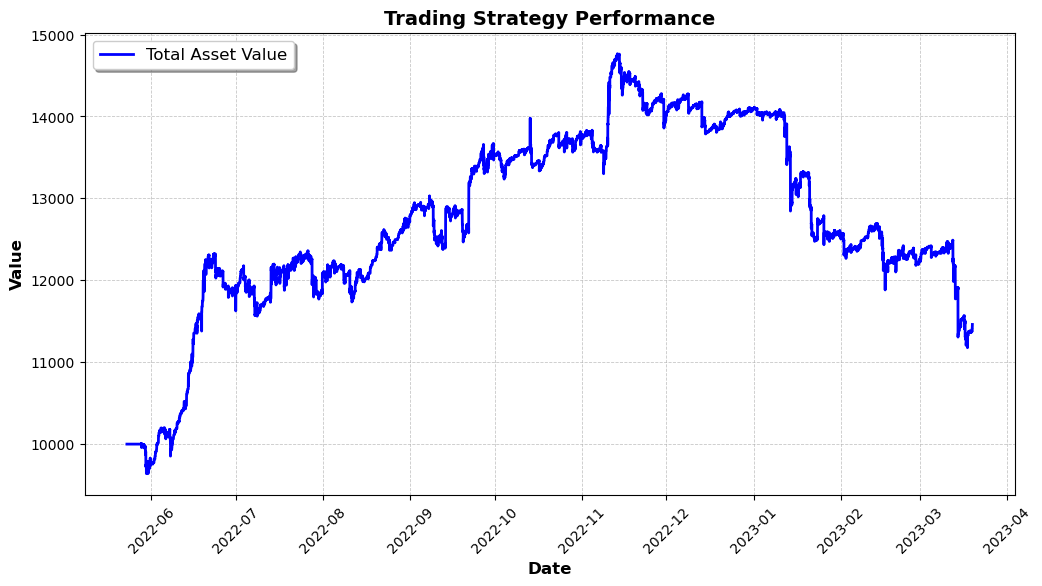

In [195]:
picture.plot_trading_performance(df_result)

In [138]:
from skopt import gp_minimize
from skopt.space import Real

df = trading_signals_df.copy()
df['Future_Return'] = BTC["close"].pct_change(periods=1).shift(-1) # Future return for evaluation

# Define rolling window parameters
rolling_window = 12*24*90  # Train on past 5000 data points
test_window = 12*24*60      # Predict for next 500 data points
step_size = 12*24*60        # Move forward 5000 steps for next training

# Initialize test signal column
df['Test_Signal'] = np.nan  

factors_name = trading_signals_df.columns

# **Step 1: Rolling window training and test signal generation**
for start in range(0, len(df) - rolling_window - test_window, step_size):
    train_end = start + rolling_window
    test_end = train_end + test_window  # Future period (test set)
    
    df_train = df.iloc[start:train_end].copy()  # Training window
    df_test = df.iloc[train_end:test_end].copy()  # Test window (next period)

    # **Calculate Sharpe ratios for training window**
    sharpe_ratios = {}
    for factor in factors_name:
        trading_signals_series = df_train[factor]
        sharpe_ratios[factor],_ = calculate_signal_sharpe(trading_signals_series, BTC)

    # Select the top-performing factors
    # Remove NaN values before sorting
    valid_sharpe_ratios = {factor: value for factor, value in sharpe_ratios.items() if not np.isnan(value) and value > 0}

    # Sort factors based on Sharpe Ratio (descending)
    top_factors = sorted(valid_sharpe_ratios, key=valid_sharpe_ratios.get, reverse=True)[:6]
    
    # **Optimize factor weights using Bayesian Optimization**
    def objective(weights):
        weights = np.array(weights)
        if weights.sum() == 0:
            weights = np.ones_like(weights) / len(weights)  # Assign equal weights if sum is zero
        else:
            weights = weights / weights.sum()
        weighted_signal = sum(w * df_train[f] for w, f in zip(weights, top_factors))
        sharpe_ratio,_ = calculate_signal_sharpe(weighted_signal, BTC)
        if np.isnan(sharpe_ratio):
            sharpe_ratio = 0
        return -sharpe_ratio  # Maximize Sharpe Ratio (negate for minimization)
    
    # Extract Sharpe Ratios for selected top factors
    sharpe_values = np.array([sharpe_ratios[f] for f in top_factors])

    # Initialize weights: Best-performing factor = 1, others = 0
    sharpe_weights = np.zeros(len(sharpe_values))  # Start with all zeros
    best_factor_index = np.argmax(sharpe_values)  # Get index of best factor
    sharpe_weights[best_factor_index] = 1  # Set the best factor weight to 1

    search_space = [Real(0, 1, name=f"{f[0]}_{f[1]}") for f in top_factors]

    result = gp_minimize(objective, search_space, n_calls=20, random_state=42, x0=[sharpe_weights.tolist()])
    optimized_weights = result.x

    # **Apply optimized weights to test window (generate test signals)**
    weighted_signal = sum(w * df_test[f] for w, f in zip(optimized_weights, top_factors))
    
    # Assign to test set
    df.loc[df.index[train_end:test_end], 'Test_Signal'] = weighted_signal.values

    print(f"Train Window {start}-{train_end} -> Test Window {train_end}-{test_end}")
    print(f"Optimized Weights: {dict(zip(top_factors, optimized_weights))}")

Train Window 0-17280 -> Test Window 17280-25920
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 0.0, ('Momentum Indicators', 'ADX14'): 0.0, ('Pattern Recognition', 'CDLUNIQUE3RIVER'): 0.009763746482363476, ('Momentum Indicators', 'TRIX'): 1.0, ('Overlap Studies', 'SAR'): 1.0, ('Overlap Studies', 'SAREXT'): 1.0}
Train Window 8640-25920 -> Test Window 25920-34560
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Pattern Recognition', 'CDLKICKINGBYLENGTH'): 0.0, ('Pattern Recognition', 'CDLBREAKAWAY'): 0.0, ('Pattern Recognition', 'CDLCOUNTERATTACK'): 0.0, ('Momentum Indicators', 'CCI10'): 0.0, ('Pattern Recognition', 'CDLTASUKIGAP'): 0.0}
Train Window 17280-34560 -> Test Window 34560-43200
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Pattern Recognition', 'CDLCOUNTERATTACK'): 0.0, ('Pattern Recognition', 'CDLTASUKIGAP'): 0.0, ('Pattern Recognition', 'CDLBREAKAWAY'): 0.0, ('Pattern Recognition', 'DLABANDONEDBABY'): 0.0, ('Pattern

In [139]:
_,df_result = calculate_signal_sharpe(df['Test_Signal'].dropna(),BTC)

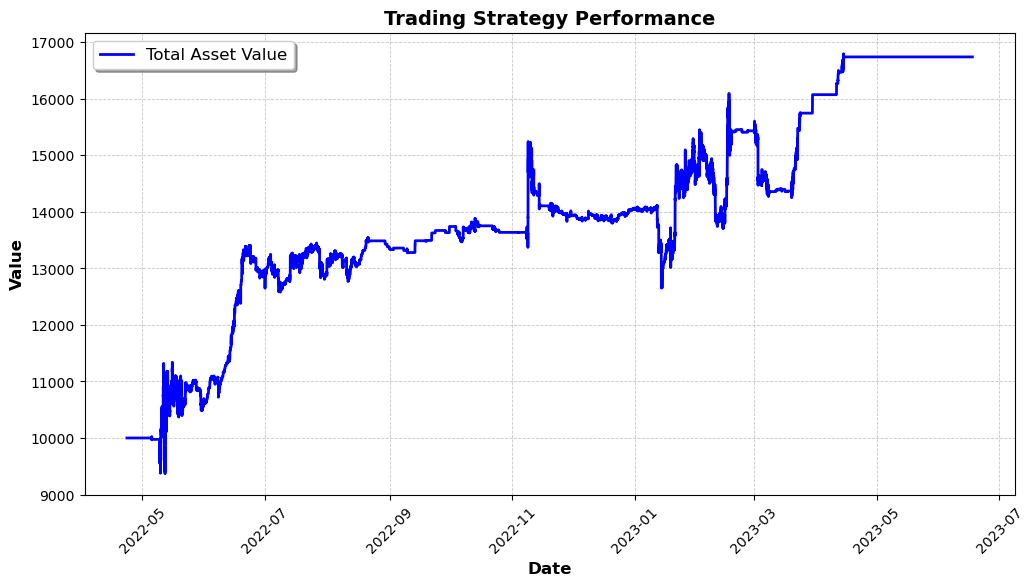

In [142]:
picture.plot_trading_performance(df_result)

In [172]:
from skopt import gp_minimize
from skopt.space import Real

# Copy the trading signals dataframe
df = trading_signals_df.copy()
df['Future_Return'] = BTC["close"].pct_change(periods=1).shift(-1)  # Future return for evaluation

# Define rolling window parameters
rolling_window = 12 * 24 * 60  # Train on past 90 days
test_window = 12 * 24 * 30      # Predict for next 60 days
step_size = 12 * 24 * 30        # Move forward 60 days for next training

# Initialize test signal column
df['Test_Signal'] = np.nan  

# Storage for Sharpe ratios per factor and per training window
sharpe_record = []
train_window_sharpe = []

factors_name = trading_signals_df.columns

# **Step 1: Rolling window training and test signal generation**
for start in range(0, len(df) - rolling_window - test_window, step_size):
    train_end = start + rolling_window
    test_end = train_end + test_window  # Future period (test set)
    
    df_train = df.iloc[start:train_end].copy()  # Training window
    df_test = df.iloc[train_end:test_end].copy()  # Test window (next period)

    # **Calculate Sharpe ratios and volatility for training window**
    sharpe_ratios = {factor: [] for factor in factors_name}

    for factor in factors_name:
        trading_signals_series = df_train[factor]
        sharpe_ratio, volatility = calculate_signal_sharpe(trading_signals_series, BTC)
        
        sharpe_ratios[factor].append(sharpe_ratio)

    # **Sort by Sharpe-to-Volatility ratio**
    sharpe_to_vol = {}

    for factor in sharpe_ratios:
        if len(sharpe_ratios[factor]) > 1:
            sharpe_to_vol[factor] = np.mean(sharpe_ratios[factor]) / np.std(sharpe_ratios[factor])
        else:
            sharpe_to_vol[factor] = np.mean(sharpe_ratios[factor]) 
    
    # **Record the Sharpe ratio per factor**
    for factor, ratio in sharpe_ratios.items():
        sharpe_record.append({
            "Start": start, "End": train_end, "Factor": factor, "Sharpe": ratio
        })

    # Sort factors based on Sharpe-to-Volatility (descending)
    top_factors = sorted(sharpe_to_vol, key=sharpe_to_vol.get, reverse=True)[:6]

    # **Optimize factor weights using Bayesian Optimization**
    def objective(weights):
        weights = np.array(weights)
        if weights.sum() == 0:
            weights = np.ones_like(weights) / len(weights)  # Assign equal weights if sum is zero
        else:
            weights = weights / weights.sum()
        weighted_signal = sum(w * df_train[f] for w, f in zip(weights, top_factors))
        sharpe_ratio, _ = calculate_signal_sharpe(weighted_signal, BTC)
        return -sharpe_ratio if not np.isnan(sharpe_ratio) else 0  # Maximize Sharpe Ratio (negate for minimization)
    
    # Extract Sharpe Ratios for selected top factors
    sharpe_values = np.array([sharpe_to_vol[f] for f in top_factors])

    # Initialize weights: Best-performing factor = 1, others = 0
    sharpe_weights = np.zeros(len(sharpe_values))  # Start with all zeros
    best_factor_index = np.argmax(sharpe_values)  # Get index of best factor
    sharpe_weights[best_factor_index] = 1  # Set the best factor weight to 1

    search_space = [Real(0, 1, name=f"{f[0]}_{f[1]}") for f in top_factors]

    result = gp_minimize(objective, search_space, n_calls=20, random_state=42, x0=[sharpe_weights.tolist()])
    optimized_weights = result.x

    # **Apply optimized weights to test window (generate test signals)**
    weighted_signal = sum(w * df_test[f] for w, f in zip(optimized_weights, top_factors))
    
    # Assign to test set
    df.loc[df.index[train_end:test_end], 'Test_Signal'] = weighted_signal.values

    # **Record the overall Sharpe ratio for this training window**
    train_sharpe, _ = calculate_signal_sharpe(weighted_signal, BTC)
    train_window_sharpe.append({
        "Train Start": start, "Train End": train_end, 
        "Test Start": train_end, "Test End": test_end, 
        "Train Sharpe": train_sharpe
    })

    print(f"Train Window {start}-{train_end} -> Test Window {train_end}-{test_end}")
    print(f"Optimized Weights: {dict(zip(top_factors, optimized_weights))}")

# Convert records to DataFrame for analysis
sharpe_df = pd.DataFrame(sharpe_record)
train_sharpe_df = pd.DataFrame(train_window_sharpe)


Train Window 0-17280 -> Test Window 17280-25920
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Momentum Indicators', 'ADX14'): 0.0, ('Momentum Indicators', 'TRIX'): 1.0, ('Overlap Studies', 'SAR'): 0.0, ('Overlap Studies', 'SAREXT'): 0.0, ('Overlap Studies', 'SMA20'): 0.0}
Train Window 8640-25920 -> Test Window 25920-34560
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Momentum Indicators', 'CCI10'): 0.0, ('Pattern Recognition', 'CDL2CROWS'): 0.0, ('Overlap Studies', 'T'): 0.0, ('Overlap Studies', 'SMA20'): 0.0, ('Overlap Studies', 'DEMA'): 0.0}
Train Window 17280-34560 -> Test Window 34560-43200
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Momentum Indicators', 'CCI10'): 0.0, ('Momentum Indicators', 'RSI5'): 0.2862209070203583, ('Momentum Indicators', 'CCI5'): 0.0, ('Momentum Indicators', 'ROC'): 0.0, ('Momentum Indicators', 'ROCR'): 0.0}
Train Window 25920-43200 -> Test Window 43200-51840
Optimized Weights: {('Ove

In [173]:
_,df_result = calculate_signal_sharpe(df['Test_Signal'].dropna(),BTC)

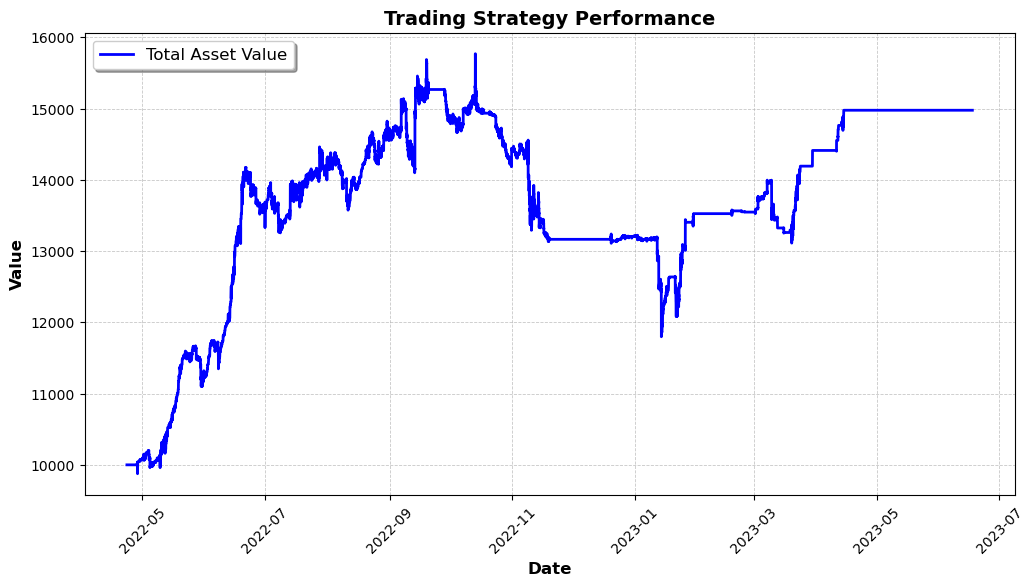

In [175]:
picture.plot_trading_performance(df_result)

In [178]:
from skopt import gp_minimize
from skopt.space import Real

# Copy the trading signals dataframe
df = trading_signals_df.copy()
df['Future_Return'] = BTC["close"].pct_change(periods=1).shift(-1)  # Future return for evaluation

# Define rolling window parameters
rolling_window = 12 * 24 * 60  # Train on past 90 days
test_window = 12 * 24 * 30      # Predict for next 60 days
step_size = 12 * 24 * 30        # Move forward 60 days for next training

# Initialize test signal column
df['Test_Signal'] = np.nan  

# Storage for Sharpe ratios per factor and per training window
sharpe_record = []
train_window_sharpe = []

factors_name = trading_signals_df.columns

# **Step 1: Rolling window training and test signal generation**
for start in range(0, len(df) - rolling_window - test_window, step_size):
    train_end = start + rolling_window
    test_end = train_end + test_window  # Future period (test set)
    
    df_train = df.iloc[start:train_end].copy()  # Training window
    df_test = df.iloc[train_end:test_end].copy()  # Test window (next period)

    # **Calculate Sharpe ratios and volatility for training window**
    sharpe_ratios = {factor: [] for factor in factors_name}

    for factor in factors_name:
        trading_signals_series = df_train[factor]
        sharpe_ratio, volatility = calculate_signal_sharpe(trading_signals_series, BTC)
        
        sharpe_ratios[factor].append(sharpe_ratio)

    # **Sort by Sharpe-to-Volatility ratio**
    sharpe_to_vol = {}

    for factor in sharpe_ratios:
        if len(sharpe_ratios[factor]) > 1:
            sharpe_to_vol[factor] = np.mean(sharpe_ratios[factor]) / np.std(sharpe_ratios[factor])
        else:
            sharpe_to_vol[factor] = np.mean(sharpe_ratios[factor]) 
    
    # **Record the Sharpe ratio per factor**
    for factor, ratio in sharpe_ratios.items():
        sharpe_record.append({
            "Start": start, "End": train_end, "Factor": factor, "Sharpe": ratio
        })

    # Sort factors based on Sharpe-to-Volatility (descending)
    top_factors = sorted(sharpe_to_vol, key=sharpe_to_vol.get, reverse=True)[:6]

    # **Optimize factor weights using Bayesian Optimization**
    def objective(weights):
        weights = np.array(weights)
        if weights.sum() == 0:
            weights = np.ones_like(weights) / len(weights)  # Assign equal weights if sum is zero
        else:
            weights = weights / weights.sum()
        weighted_signal = sum(w * df_train[f] for w, f in zip(weights, top_factors))
        sharpe_ratio, _ = calculate_signal_sharpe(weighted_signal, BTC)
        return -sharpe_ratio if not np.isnan(sharpe_ratio) else 0  # Maximize Sharpe Ratio (negate for minimization)
    
    # Extract Sharpe Ratios for selected top factors
    sharpe_values = np.array([sharpe_to_vol[f] for f in top_factors])

    # Initialize weights: Best-performing factor = 1, others = 0
    sharpe_weights = np.zeros(len(sharpe_values))  # Start with all zeros
    best_factor_index = np.argmax(sharpe_values)  # Get index of best factor
    sharpe_weights[best_factor_index] = 1  # Set the best factor weight to 1

    search_space = [Real(0, 1, name=f"{f[0]}_{f[1]}") for f in top_factors]

    result = gp_minimize(objective, search_space, n_calls=20, random_state=42, x0=[sharpe_weights.tolist()])
    optimized_weights = result.x

    optimized_weights = optimized_weights / np.sum(optimized_weights) 
        
    # **Apply optimized weights to test window (generate test signals)**
    weighted_signal = sum(w * df_test[f] for w, f in zip(optimized_weights, top_factors))
    
    # Assign to test set
    df.loc[df.index[train_end:test_end], 'Test_Signal'] = weighted_signal.values

    # **Record the overall Sharpe ratio for this training window**
    train_sharpe, _ = calculate_signal_sharpe(weighted_signal, BTC)
    train_window_sharpe.append({
        "Train Start": start, "Train End": train_end, 
        "Test Start": train_end, "Test End": test_end, 
        "Train Sharpe": train_sharpe
    })

    print(f"Train Window {start}-{train_end} -> Test Window {train_end}-{test_end}")
    print(f"Optimized Weights: {dict(zip(top_factors, optimized_weights))}")

# Convert records to DataFrame for analysis
sharpe_df = pd.DataFrame(sharpe_record)
train_sharpe_df = pd.DataFrame(train_window_sharpe)


Train Window 0-17280 -> Test Window 17280-25920
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 0.5, ('Momentum Indicators', 'ADX14'): 0.0, ('Momentum Indicators', 'TRIX'): 0.5, ('Overlap Studies', 'SAR'): 0.0, ('Overlap Studies', 'SAREXT'): 0.0, ('Overlap Studies', 'SMA20'): 0.0}
Train Window 8640-25920 -> Test Window 25920-34560
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Momentum Indicators', 'CCI10'): 0.0, ('Pattern Recognition', 'CDL2CROWS'): 0.0, ('Overlap Studies', 'T'): 0.0, ('Overlap Studies', 'SMA20'): 0.0, ('Overlap Studies', 'DEMA'): 0.0}
Train Window 17280-34560 -> Test Window 34560-43200
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 0.7774714238758459, ('Momentum Indicators', 'CCI10'): 0.0, ('Momentum Indicators', 'RSI5'): 0.22252857612415408, ('Momentum Indicators', 'CCI5'): 0.0, ('Momentum Indicators', 'ROC'): 0.0, ('Momentum Indicators', 'ROCR'): 0.0}
Train Window 25920-43200 -> Test Window 43200-51840
Optimized

In [179]:
_,df_result = calculate_signal_sharpe(df['Test_Signal'].dropna(),BTC)

In [180]:
_

1.9625310141715415

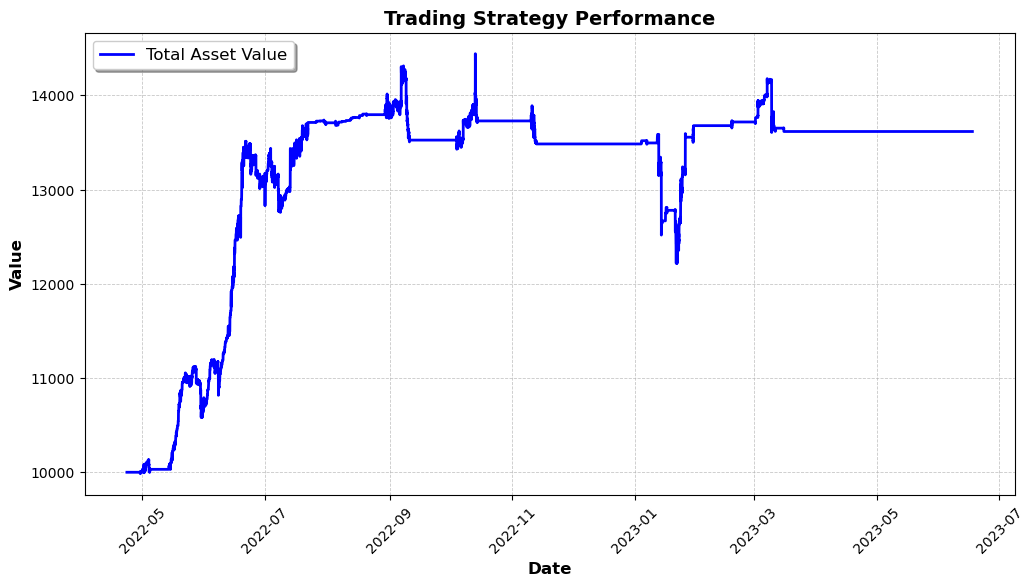

In [181]:
picture.plot_trading_performance(df_result)

In [184]:
factors_corr = df_indicators_detrend.corr()

In [185]:
factors_corr

Category                                Overlap Studies                     \
Factor                                      BBAND WIDTH BBAND UPPER SIGNAL   
Category            Factor                                                   
Overlap Studies     BBAND WIDTH                1.000000           0.003885   
                    BBAND UPPER SIGNAL         0.003885           1.000000   
                    BBAND LOWER SIGNAL         0.012896          -0.061064   
                    RSI                       -0.015144           0.439435   
                    DEMA                      -0.189558          -0.001016   
...                                                 ...                ...   
Pattern Recognition CDLUPSIDEGAP2CROWS         0.000603           0.001446   
                    CDLXSIDEGAP3METHODS        0.005368          -0.001025   
Cycle Indicators    HTDCPERIOD                 0.201695          -0.022874   
                    HT DCPHASE                -0.073823           0.044305   
                    TRENDMODE                  0.239295           0.086275   

Category                                                              \
Factor                                  BBAND LOWER SIGNAL       RSI   
Category            Factor                                             
Overlap Studies     BBAND WIDTH                   0.012896 -0.015144   
                    BBAND UPPER SIGNAL           -0.061064  0.439435   
                    BBAND LOWER SIGNAL            1.000000 -0.446224   
                    RSI                          -0.446224  1.000000   
                    DEMA                          0.002822 -0.008829   
...                                                    ...       ...   
Pattern Recognition CDLUPSIDEGAP2CROWS            0.001448 -0.001610   
                    CDLXSIDEGAP3METHODS          -0.000522  0.011365   
Cycle Indicators    HTDCPERIOD                   -0.028585  0.011989   
                    HT DCPHASE                   -0.039239  0.183016   
                    TRENDMODE                     0.083047  0.006668   

Category                                                                 \
Factor                                       DEMA       EMA H TRENDLINE   
Category            Factor                                                
Overlap Studies     BBAND WIDTH         -0.189558 -0.189527   -0.189329   
                    BBAND UPPER SIGNAL  -0.001016 -0.003826   -0.005624   
                    BBAND LOWER SIGNAL   0.002822  0.005536    0.007477   
                    RSI                 -0.008829 -0.018516   -0.025122   
                    DEMA                 1.000000  0.999785    0.999438   
...                                           ...       ...         ...   
Pattern Recognition CDLUPSIDEGAP2CROWS   0.000983  0.000959    0.000971   
                    CDLXSIDEGAP3METHODS -0.004773 -0.004942   -0.005110   
Cycle Indicators    HTDCPERIOD          -0.046182 -0.046485   -0.046647   
                    HT DCPHASE           0.003065 -0.004771   -0.009440   
                    TRENDMODE            0.024185  0.024433    0.023970   

Category                                                               ...  \
Factor                                       KMAM  MIDPOINT  MIDPRICE  ...   
Category            Factor                                             ...   
Overlap Studies     BBAND WIDTH         -0.189523 -0.189421 -0.189352  ...   
                    BBAND UPPER SIGNAL  -0.001954 -0.001788 -0.001501  ...   
                    BBAND LOWER SIGNAL   0.003708  0.003527  0.003283  ...   
                    RSI                 -0.012769 -0.015632 -0.015190  ...   
                    DEMA                 0.999888  0.999879  0.999838  ...   
...                                           ...       ...       ...  ...   
Pattern Recognition CDLUPSIDEGAP2CROWS   0.000952  0.000979  0.000994  ...   
                    CDLXSIDEGAP3METHODS -0.004834 -0.004886 -0.0049

In [186]:
all_factors_index = trading_signals_df.columns
# Set to store factors that should be removed
factors_to_remove = set()

# Iterate over the correlation matrix to find highly correlated factors
for i in range(len(all_factors_index)):
    for j in range(i + 1, len(all_factors_index)):
        factor1 = all_factors_index[i]
        factor2 = all_factors_index[j]

        # If correlation is greater than 0.7, remove the lower-ranked factor
        if factors_corr.loc[factor1, factor2] > 0.7:
            factors_to_remove.add(factor2)

# Filter the top factors index to exclude highly correlated ones
filtered_top_factors_index = [factor for factor in all_factors_index if factor not in factors_to_remove]

In [188]:
len(filtered_top_factors_index)

82

In [ ]:
factors_name = filtered_top_factors_index

In [189]:
from skopt import gp_minimize
from skopt.space import Real

# Copy the trading signals dataframe
df = trading_signals_df.copy()
df['Future_Return'] = BTC["close"].pct_change(periods=1).shift(-1)  # Future return for evaluation

# Define rolling window parameters
rolling_window = 12 * 24 * 60  # Train on past 90 days
test_window = 12 * 24 * 30      # Predict for next 60 days
step_size = 12 * 24 * 30        # Move forward 60 days for next training

# Initialize test signal column
df['Test_Signal'] = np.nan  

# Storage for Sharpe ratios per factor and per training window
sharpe_record = []
train_window_sharpe = []

# **Step 1: Rolling window training and test signal generation**
for start in range(0, len(df) - rolling_window - test_window, step_size):
    train_end = start + rolling_window
    test_end = train_end + test_window  # Future period (test set)
    
    df_train = df.iloc[start:train_end].copy()  # Training window
    df_test = df.iloc[train_end:test_end].copy()  # Test window (next period)

    # **Calculate Sharpe ratios and volatility for training window**
    sharpe_ratios = {factor: [] for factor in factors_name}

    for factor in factors_name:
        trading_signals_series = df_train[factor]
        sharpe_ratio, volatility = calculate_signal_sharpe(trading_signals_series, BTC)
        
        sharpe_ratios[factor].append(sharpe_ratio)

    # **Sort by Sharpe-to-Volatility ratio**
    sharpe_to_vol = {}

    for factor in sharpe_ratios:
        if len(sharpe_ratios[factor]) > 1:
            sharpe_to_vol[factor] = np.mean(sharpe_ratios[factor]) / np.std(sharpe_ratios[factor])
        else:
            sharpe_to_vol[factor] = np.mean(sharpe_ratios[factor]) 
    
    # **Record the Sharpe ratio per factor**
    for factor, ratio in sharpe_ratios.items():
        sharpe_record.append({
            "Start": start, "End": train_end, "Factor": factor, "Sharpe": ratio
        })

    # Sort factors based on Sharpe-to-Volatility (descending)
    top_factors = sorted(sharpe_to_vol, key=sharpe_to_vol.get, reverse=True)[:6]

    # **Optimize factor weights using Bayesian Optimization**
    def objective(weights):
        weights = np.array(weights)
        if weights.sum() == 0:
            weights = np.ones_like(weights) / len(weights)  # Assign equal weights if sum is zero
        else:
            weights = weights / weights.sum()
        weighted_signal = sum(w * df_train[f] for w, f in zip(weights, top_factors))
        sharpe_ratio, _ = calculate_signal_sharpe(weighted_signal, BTC)
        return -sharpe_ratio if not np.isnan(sharpe_ratio) else 0  # Maximize Sharpe Ratio (negate for minimization)
    
    # Extract Sharpe Ratios for selected top factors
    sharpe_values = np.array([sharpe_to_vol[f] for f in top_factors])

    # Initialize weights: Best-performing factor = 1, others = 0
    sharpe_weights = np.zeros(len(sharpe_values))  # Start with all zeros
    best_factor_index = np.argmax(sharpe_values)  # Get index of best factor
    sharpe_weights[best_factor_index] = 1  # Set the best factor weight to 1

    search_space = [Real(0, 1, name=f"{f[0]}_{f[1]}") for f in top_factors]

    result = gp_minimize(objective, search_space, n_calls=20, random_state=42, x0=[sharpe_weights.tolist()])
    optimized_weights = result.x

    # optimized_weights = optimized_weights / np.sum(optimized_weights) 
        
    # **Apply optimized weights to test window (generate test signals)**
    weighted_signal = sum(w * df_test[f] for w, f in zip(optimized_weights, top_factors))
    
    # Assign to test set
    df.loc[df.index[train_end:test_end], 'Test_Signal'] = weighted_signal.values

    # **Record the overall Sharpe ratio for this training window**
    train_sharpe, _ = calculate_signal_sharpe(weighted_signal, BTC)
    train_window_sharpe.append({
        "Train Start": start, "Train End": train_end, 
        "Test Start": train_end, "Test End": test_end, 
        "Train Sharpe": train_sharpe
    })

    print(f"Train Window {start}-{train_end} -> Test Window {train_end}-{test_end}")
    print(f"Optimized Weights: {dict(zip(top_factors, optimized_weights))}")

# Convert records to DataFrame for analysis
sharpe_df = pd.DataFrame(sharpe_record)
train_sharpe_df = pd.DataFrame(train_window_sharpe)

KeyboardInterrupt: 

In [6]:
start = "2022-01-01 06:00:00"
end = "2022-12-31 06:00:00"

df_with_indicators = factors.compute_technical_indicators(BTC, start, end)
df_result = df_with_indicators.iloc[120:].copy()

labels = labeling.generate_labels(BTC, price_col='close')
labels = labels.iloc[120:]


df_final = df_result.copy()
df_final['label'] = labels
df_final = df_final.infer_objects(copy=False)
pd.set_option('future.no_silent_downcasting', True)
df_final.fillna(0, inplace=True)

In [7]:
import pandas as pd

# Function to convert string columns to float
def convert_string_to_float(df):
    # Identify columns with string (object) data type
    string_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # Convert string columns to float where possible
    for col in string_columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float, set errors to NaN if conversion fails
        except Exception as e:
            print(f"Error converting column {col} to float: {e}")
    
    return df


# Convert string columns to float
BTC = convert_string_to_float(BTC)

In [8]:
# 选择滚动窗口大小
window_size = 15000  

# 计算移动平均
moving_avg = BTC.rolling(window=window_size).mean()

# 去趋势（原值 - 移动平均值）
detrended_series = BTC - moving_avg
detrended_series = detrended_series.dropna()

In [9]:
df_with_indicators = factors.compute_technical_indicators(detrended_series, start, end)
df_restructed_indicators = factors.restructure_dataframe(df_with_indicators)

In [10]:
# Define the future return intervals
future_intervals = [5, 10, 15, 20, 25, 30]

# Compute future returns and store in a dictionary
future_returns = {
    f"Future {interval}m Return": df_final["close"].pct_change(periods=interval).shift(-interval) for interval in future_intervals
}

# Convert the dictionary to a DataFrame with MultiIndex columns
future_returns_df = pd.DataFrame(future_returns, index=df_final.index)
future_returns_df.columns = pd.MultiIndex.from_tuples([("Revenue", col) for col in future_returns_df.columns],
                                                      names=["Category", "Factor"])

# Concatenate the original DataFrame with the new future return columns
df_extended = pd.concat([df_restructed_indicators, future_returns_df], axis=1)

In [11]:
# Compute correlation of all factors with each future return under the "Revenue" category
revenue_columns = [col for col in df_extended.columns if col[0] == "Revenue"]

# Compute correlation between factors and future returns
factor_correlations = df_extended.corr().loc[:, revenue_columns].drop(index=revenue_columns)


In [12]:
import numpy as np
import pandas as pd

# Step 1: 数据清理 - 删除无效列
df_cleaned = df_restructed_indicators.dropna(axis=1, how="all")  # 删除全是 NaN 的列
df_cleaned = df_cleaned.loc[:, df_cleaned.nunique() > 1]  # 删除只有单一值的列

# Step 2: 计算每列的唯一值个数
column_unique_counts = df_cleaned.nunique()

# Step 3: 交易信号字典
trading_signals = {}

# 定义分位数
quantile_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95]  # 十分位数

# 目标因子
target_revenue_factor = ("Revenue", "Future 5m Return")

# 确保目标因子存在
if target_revenue_factor in factor_correlations.columns:
    target_correlations = factor_correlations[target_revenue_factor]
else:
    raise ValueError("Future 5m Return column not found in factor_correlations.")

# 遍历每个因子
for (category, factor_name), corr_value in target_correlations.items():
    if (category, factor_name) in df_cleaned.columns:
        factor_values = df_cleaned[(category, factor_name)]

        unique_count = column_unique_counts[(category, factor_name)]
        unique_vals_sorted = sorted(factor_values.unique())  # 获取唯一值并排序

        # **2 个唯一值 - 分配 (0, 5) 或 (0, -5)**
        if unique_count == 2:
            signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 5}
            signal = factor_values.map(signal_map).fillna(0)
        
        # **3 个唯一值 - 分配 (0, 5, -5)**
        elif unique_count == 3:
            signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 5, unique_vals_sorted[2]: -5}
            signal = factor_values.map(signal_map).fillna(0)

        # **5 个唯一值 - 分配 (0, 1, -1, 5, -5)**
        elif unique_count == 5:
            signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1, unique_vals_sorted[2]: -1, 
                          unique_vals_sorted[3]: 5, unique_vals_sorted[4]: -5}
            signal = factor_values.map(signal_map).fillna(0)

        # **对于一般数值因子（>5个唯一值），使用十分位数计算**
        else:
            # 计算分位数
            q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = factor_values.quantile(quantile_levels).values

            # 生成信号
            signal = np.select(
                [
                    factor_values >= q10, 
                    (factor_values >= q9) & (factor_values < q10),
                    (factor_values >= q8) & (factor_values < q9),
                    (factor_values >= q7) & (factor_values < q8),
                    (factor_values >= q6) & (factor_values < q7),
                    (factor_values >= q5) & (factor_values < q6),
                    (factor_values >= q4) & (factor_values < q5),
                    (factor_values >= q3) & (factor_values < q4),
                    (factor_values >= q2) & (factor_values < q3),
                    (factor_values >= q1) & (factor_values < q2),
                    factor_values < q1
                ],
                [5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5]
            )

        # **调整信号方向**
        if corr_value < 0:
            signal = -signal  # 反转信号方向

        trading_signals[(category, factor_name)] = signal

# 转换为 DataFrame
trading_signals_df = pd.DataFrame(trading_signals, index=df_cleaned.index)
trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_df.columns, names=["Category", "Factor"])

In [52]:
import trading_signal  

importlib.reload(trading_signal)

from trading_signal import vol_long_short_strategy

In [50]:
import numpy as np
import pandas as pd

# 计算历史波动率（Realized Volatility）
def realized_volatility(prices, window=5*24*12):
    log_returns = np.log(prices / prices.shift(1))  # 计算对数收益率
    rolling_vol = log_returns.rolling(window=window).std() *100
    return rolling_vol

# 计算波动率
df_final["volatility"] = realized_volatility(df_final["close"])

In [20]:
future_returns_df

Category                     Revenue                                      \
Factor              Future 5m Return Future 10m Return Future 15m Return   
date                                                                       
2022-01-01 16:00:00         0.004522          0.000140          0.000274   
2022-01-01 16:05:00         0.002285         -0.001608         -0.001923   
2022-01-01 16:10:00        -0.000253         -0.001803         -0.001906   
2022-01-01 16:15:00         0.000683         -0.002489          0.001126   
2022-01-01 16:20:00        -0.000441         -0.002655          0.007188   
...                              ...               ...               ...   
2022-12-31 05:40:00              NaN               NaN               NaN   
2022-12-31 05:45:00              NaN               NaN               NaN   
2022-12-31 05:50:00              NaN               NaN               NaN   
2022-12-31 05:55:00              NaN               NaN               NaN   
2022-12-31 06:00:00              NaN               NaN               NaN   

Category                                                                   
Factor              Future 20m Return Future 25m Return Future 30m Return  
date                                                                       
2022-01-01 16:00:00          0.012810          0.011268          0.004257  
2022-01-01 16:05:00          0.008827          0.008315          0.002288  
2022-01-01 16:10:00          0.007629          0.004838          0.000890  
2022-01-01 16:15:00          0.007601          0.006274          0.002669  
2022-01-01 16:20:00          0.006961          0.005799          0.002827  
...                               ...               ...               ...  
2022-12-31 05:40:00               NaN               NaN               NaN  
2022-12-31 05:45:00               NaN               NaN               NaN  
2022-12-31 05:50:00               NaN               NaN               NaN  
2022-12-31 05:55:00               NaN               NaN               NaN  
2022-12-31 06:00:00               NaN               NaN               NaN  

[104707 rows x 6 columns]

In [55]:
def calculate_signal_sharpe(trading_signals_series,df_final):
    series_position_long_short = vol_long_short_strategy(trading_signals_series,df_final['volatility'])

    # Calculate the cumulative asset value
    df_result = calculate_cumulative_asset(df_final["close"], series_position_long_short)

    # Evaluate the strategy and store results
    evaluation_metrics = evaluate_strategy(df_result, risk_free_rate=0.0)
    
    return evaluation_metrics["Sharpe Ratio"],df_result


In [22]:
trading_signals_df

Category            Overlap Studies                                        \
Factor                  BBAND WIDTH BBAND UPPER SIGNAL BBAND LOWER SIGNAL   
date                                                                        
2022-02-22 08:30:00               0                  0                  0   
2022-02-22 08:35:00               0                  0                  0   
2022-02-22 08:40:00               0                  0                  0   
2022-02-22 08:45:00               0                  0                  0   
2022-02-22 08:50:00               0                  0                  0   
...                             ...                ...                ...   
2022-12-31 05:40:00               5                  0                  0   
2022-12-31 05:45:00               5                  0                  0   
2022-12-31 05:50:00               5                  0                  0   
2022-12-31 05:55:00               5                  0                  0   
2022-12-31 06:00:00               5                  0                  0   

Category                                                             ...  \
Factor              DEMA EMA H TRENDLINE KMAM MIDPOINT MIDPRICE SAR  ...   
date                                                                 ...   
2022-02-22 08:30:00    0   0           0    0        0        0   0  ...   
2022-02-22 08:35:00    0   0           0    0        0        0   2  ...   
2022-02-22 08:40:00    0   0           0    0        0        0   2  ...   
2022-02-22 08:45:00    0   0           0    0        0        0   2  ...   
2022-02-22 08:50:00    0   0           0    0        0        0   2  ...   
...                  ...  ..         ...  ...      ...      ...  ..  ...   
2022-12-31 05:40:00    0   0           0    0        0        0   0  ...   
2022-12-31 05:45:00    0   0           0    0        0        0   0  ...   
2022-12-31 05:50:00    0   0           0    0        0        0   0  ...   
2022-12-31 05:55:00    0   0           0    0        0        0   0  ...   
2022-12-31 06:00:00    0   0           0    0        0        0   0  ...   

Category            Pattern Recognition                                      \
Factor                 CDLSTICKSANDWICH CDLTAKURI CDLTASUKIGAP CDLTHRUSTING   
date                                                                          
2022-02-22 08:30:00                   0         0           -5           -5   
2022-02-22 08:35:00                   0         0           -5           -5   
2022-02-22 08:40:00                   0         0           -5           -5   
2022-02-22 08:45:00                   0         0           -5           -5   
2022-02-22 08:50:00                   0         0           -5           -5   
...                                 ...       ...          ...          ...   
2022-12-31 05:40:00                   0         0           -5           -5   
2022-12-31 05:45:00                   0         0           -5           -5   
2022-12-31 05:50:00                   0         0           -5           -5   
2022-12-31 05:55:00                   0         0           -5           -5   
2022-12-31 06:00:00                   0         0           -5            0   

Category                                                                    \
Factor              CDLUNIQUE3RIVER CDLUPSIDEGAP2CROWS CDLXSIDEGAP3METHODS   
date                                                                         
2022-02-22 08:30:00               0                  5                   5   
2022-02-22 08:35:00               0                  5                   5   
2022-02-22 08:40:00               0                  5                   5   
2022-02-22 08:45:00               0                  5                   5   
2022-02-22 08:50:00               0                  5                   5   
...                             ...                ...                 ...   
2022-12-31 05:40:00               0            

In [81]:
factors_name = trading_signals_df.columns

In [95]:
import numpy as np
import pandas as pd
from skopt import gp_minimize
from skopt.space import Real

df = trading_signals_df.copy()
df['Future_Return'] = future_returns_df['Revenue']['Future 5m Return']  # Future return for evaluation

# Define rolling window parameters
rolling_window = 12*24*60  # Train on past 5000 data points
test_window = 12*24*30      # Predict for next 500 data points
step_size = 12*24*30        # Move forward 5000 steps for next training

# Initialize test signal column
df['Test_Signal'] = np.nan  

# **Step 1: Rolling window training and test signal generation**
for start in range(0, len(df) - rolling_window - test_window, step_size):
    train_end = start + rolling_window
    test_end = train_end + test_window  # Future period (test set)
    
    df_train = df.iloc[start:train_end].copy()  # Training window
    df_test = df.iloc[train_end:test_end].copy()  # Test window (next period)

    # **Calculate Sharpe ratios for training window**
    sharpe_ratios = {}
    for factor in factors_name:
        trading_signals_series = df_train[factor]
        sharpe_ratios[factor],_ = calculate_signal_sharpe(trading_signals_series, df_final)

    # Select the top-performing factors
    # Remove NaN values before sorting
    valid_sharpe_ratios = {factor: value for factor, value in sharpe_ratios.items() if not np.isnan(value) and value > 0}

    # Sort factors based on Sharpe Ratio (descending)
    top_factors = sorted(valid_sharpe_ratios, key=valid_sharpe_ratios.get, reverse=True)[:6]
    
    # **Optimize factor weights using Bayesian Optimization**
    def objective(weights):
        weights = np.array(weights)
        if weights.sum() == 0:
            weights = np.ones_like(weights) / len(weights)  # Assign equal weights if sum is zero
        else:
            weights = weights / weights.sum()
        weighted_signal = sum(w * df_train[f] for w, f in zip(weights, top_factors))
        sharpe_ratio,_ = calculate_signal_sharpe(weighted_signal, df_final)
        if np.isnan(sharpe_ratio):
            sharpe_ratio = 0
        return -sharpe_ratio  # Maximize Sharpe Ratio (negate for minimization)
    
    # Extract Sharpe Ratios for selected top factors
    sharpe_values = np.array([sharpe_ratios[f] for f in top_factors])

    # Initialize weights: Best-performing factor = 1, others = 0
    sharpe_weights = np.zeros(len(sharpe_values))  # Start with all zeros
    best_factor_index = np.argmax(sharpe_values)  # Get index of best factor
    sharpe_weights[best_factor_index] = 1  # Set the best factor weight to 1

    search_space = [Real(0, 1, name=f"{f[0]}_{f[1]}") for f in top_factors]

    result = gp_minimize(objective, search_space, n_calls=20, random_state=42, x0=[sharpe_weights.tolist()])
    optimized_weights = result.x

    # **Apply optimized weights to test window (generate test signals)**
    weighted_signal = sum(w * df_test[f] for w, f in zip(optimized_weights, top_factors))
    
    # Assign to test set
    df.loc[df.index[train_end:test_end], 'Test_Signal'] = weighted_signal.values

    print(f"Train Window {start}-{train_end} -> Test Window {train_end}-{test_end}")
    print(f"Optimized Weights: {dict(zip(top_factors, optimized_weights))}")


Train Window 0-17280 -> Test Window 17280-25920
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Pattern Recognition', 'CDLUNIQUE3RIVER'): 0.0, ('Momentum Indicators', 'MINUS_DM'): 0.0, ('Pattern Recognition', 'CDLKICKINGBYLENGTH'): 0.0, ('Overlap Studies', 'KMAM'): 0.0, ('Overlap Studies', 'MIDPRICE'): 0.0}
Train Window 8640-25920 -> Test Window 25920-34560
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Pattern Recognition', 'CDLKICKINGBYLENGTH'): 0.0, ('Pattern Recognition', 'CDLBREAKAWAY'): 0.0, ('Pattern Recognition', 'CDLCOUNTERATTACK'): 0.0, ('Pattern Recognition', 'CDLTASUKIGAP'): 0.0, ('Pattern Recognition', 'CDL2CROWS'): 0.0}
Train Window 17280-34560 -> Test Window 34560-43200
Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 1.0, ('Pattern Recognition', 'CDLCOUNTERATTACK'): 0.0, ('Pattern Recognition', 'CDLTASUKIGAP'): 0.0, ('Pattern Recognition', 'CDLBREAKAWAY'): 0.0, ('Pattern Recognition', 'DLABANDONEDBABY'): 0.0, ('

In [96]:
_,df_result = calculate_signal_sharpe(df['Test_Signal'].dropna(),df_final)

In [99]:
_

3.9050517750695253

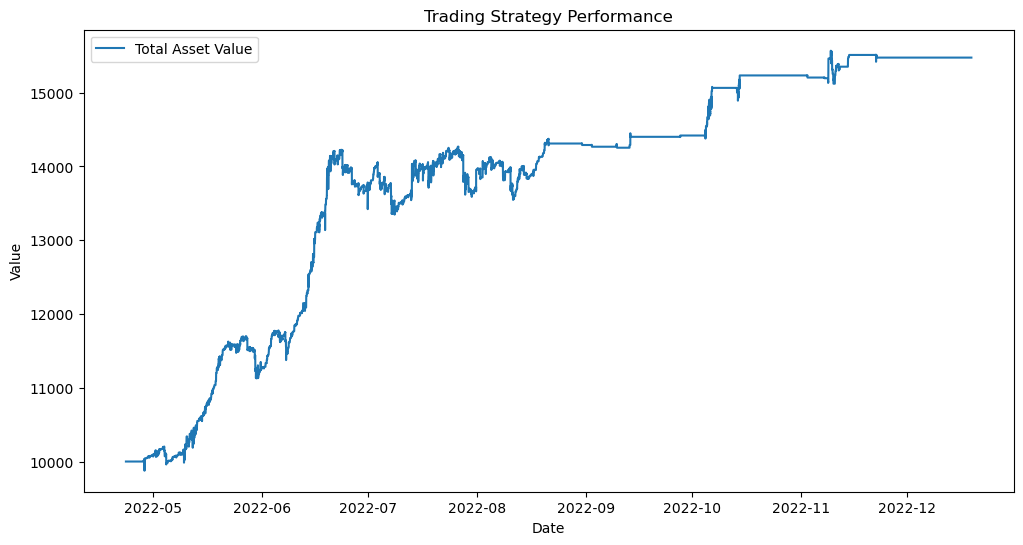

In [98]:
import matplotlib.pyplot as plt

# Plot Total Asset Value, Cash Balance, and Crypto Holdings Value
plt.figure(figsize=(12,6))

# Plot total asset value
plt.plot(df_result.index, df_result["Cumulative_Asset"], label="Total Asset Value")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Trading Strategy Performance")

# Show legend
plt.legend()

# Show the plot
plt.show()

In [29]:
import numpy as np
import pandas as pd
from skopt import gp_minimize
from skopt.space import Real

df = trading_signals_df.copy()
# 假设 df 包含 5 分钟的股票数据，并有多个技术因子
factors = [('Overlap Studies', 'BBAND UPPER SIGNAL'),
            ('Pattern Recognition', 'DLCONCEALBABYSWALL'),
            ('Pattern Recognition', 'CDLEVENINGDOJISTAR'),
            ('Pattern Recognition', 'CDLTASUKIGAP'),
            ('Pattern Recognition', 'DLABANDONEDBABY'),
            ('Pattern Recognition', 'CDLUNIQUE3RIVER'),
            ('Pattern Recognition', 'CDL3LINESTRIKE'),
            ('Pattern Recognition', 'CDL2CROWS'),
            ('Pattern Recognition', 'CDLINNECK'),
            ('Pattern Recognition', 'CDL3OUTSIDE'),
            ('Pattern Recognition', 'CDLHANGINGMAN'),
            ('Pattern Recognition', 'CDLLONGLINE'),
            ('Pattern Recognition', 'CDLCOUNTERATTACK'),
            ('Pattern Recognition', 'CDLDOJISTAR'),
            ('Pattern Recognition', 'CDLTHRUSTING'),
            ('Pattern Recognition', 'CDL3BLACKCROWS'),
            ('Pattern Recognition', 'CDLMORNINGDOJISTAR'),
            ('Pattern Recognition', 'CDLSHOOTINGSTAR'),
            ('Pattern Recognition', 'CDLEVENINGSTAR'),
            ('Pattern Recognition', 'CDLADVANCEBLOCK'),
            ('Pattern Recognition', 'CDLONNECK'),
            ('Pattern Recognition', 'CDLSTALLEDPATTERN'),
            ('Pattern Recognition', 'CDLSEPARATINGLINES'),
            ('Pattern Recognition', 'DLHARAMICROSS'),
            ('Pattern Recognition', 'CDLHIGHWAVE'),
            ('Pattern Recognition', 'CDLBREAKAWAY'),
            ('Pattern Recognition', 'CDLSHORTLINE'),
            ('Pattern Recognition', 'CDLKICKINGBYLENGTH'),
            ('Cycle Indicators', 'HT DCPHASE'),
            ('Momentum Indicators', 'ADX20')]
df['Future_Return'] = future_returns_df['Revenue']['Future 5m Return']  # 未来 5 分钟收益率

# 滚动窗口参数
rolling_window = 5000  # 过去 500 条数据（约 2500 分钟 = 4 小时）
step_size = 5000  # 每 50 步重新优化一次

# 存储最终信号
df['Final_Signal'] = 0.0  

# **Step 1: 使用滚动窗口计算夏普比率并优化因子权重**
for start in range(0, len(df) - rolling_window, step_size):
    end = start + rolling_window
    df_window = df.iloc[start:end].copy()  # 取当前窗口的数据

    # **计算夏普比率**
    sharpe_ratios = {}
    for factor in factors:
        trading_signals_series = df_window[factor]
        sharpe_ratios[factor] = calculate_signal_sharpe(trading_signals_series,df_final)

    # 选择夏普比率最高的因子
    top_factors = sorted(sharpe_ratios, key=sharpe_ratios.get, reverse=True)[:3]
    
    # **贝叶斯优化因子权重**
    def objective(weights):
        # Ensure the shape matches the target DataFrame slice
        weighted_signal = sum(w * df_window[f] for w, f in zip(weights, top_factors))
        strategy_return = weighted_signal * df_window['Future_Return']
        sharpe_ratio = strategy_return.mean() / strategy_return.std()
        return -sharpe_ratio  # 目标是最大化夏普比率，因此取负值

    # 解决 "Dimension's name must be either string or None" 的问题
    search_space = [Real(0, 1, name=f"{f[0]}_{f[1]}") for f in top_factors]

    result = gp_minimize(objective, search_space, n_calls=20, random_state=42)
    optimized_weights = result.x

    # **计算当前窗口内的交易信号**
    #df.loc[df.index[start:end], 'Final_Signal'] = sum(w * df.loc[df.index[start:end], f] for w, f in zip(optimized_weights, top_factors))
    weighted_signal = sum(w * df.loc[df.index[start:end], f] for w, f in zip(optimized_weights, top_factors))

    df.loc[df.index[start:end], 'Final_Signal'] = weighted_signal.values
    
    
    print(f"Window {start}-{end}: Optimized Weights: {dict(zip(top_factors, optimized_weights))}")



Window 0-5000: Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 0.6174815096277166, ('Pattern Recognition', 'DLCONCEALBABYSWALL'): 0.611653160488281, ('Pattern Recognition', 'CDLUNIQUE3RIVER'): 0.007066305219717408}
Window 5000-10000: Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 0.09060643453282081, ('Pattern Recognition', 'DLCONCEALBABYSWALL'): 0.6183860093330874, ('Pattern Recognition', 'CDLMORNINGDOJISTAR'): 0.38246199126716285}
Window 10000-15000: Optimized Weights: {('Pattern Recognition', 'DLCONCEALBABYSWALL'): 0.6202934732202806, ('Pattern Recognition', 'CDLMORNINGDOJISTAR'): 0.14756954036627215, ('Pattern Recognition', 'CDLKICKINGBYLENGTH'): 0.14976350483695713}
Window 15000-20000: Optimized Weights: {('Overlap Studies', 'BBAND UPPER SIGNAL'): 0.02906456133139724, ('Pattern Recognition', 'DLCONCEALBABYSWALL'): 0.18320931533079712, ('Pattern Recognition', 'CDLTHRUSTING'): 0.00015344695841001957}


KeyboardInterrupt: 

In [28]:
optimized_weights

[0.6174815096277166, 0.611653160488281, 0.007066305219717408]

In [26]:
search_space = [Real(0, 1, name=f) for f in top_factors]

ValueError: Dimension's name must be either string or None.

In [25]:
top_factors

[('Overlap Studies', 'BBAND UPPER SIGNAL'),
 ('Pattern Recognition', 'DLCONCEALBABYSWALL'),
 ('Pattern Recognition', 'CDLUNIQUE3RIVER')]